# **1. Описание проекта**

Существует база данных, содержащая сведения о музыкальных произведениях, некоторых их характеристиках и жанрах. Стоит задача разработать модель, которая будет предсказывать музыкальный жанр произведения по его характеристикам. Применение такой модели сможет улучшить работу стриминговых сервисов в плане применения рекомендательных систем.

## **Данные**

* train.csv - информация (~20000) музыкальных треках, которые будут использоваться в качестве обучающих данных.
* test.csv - информация (~5000) музыкальных треках, которые будут использоваться в качестве тестовых данных. Ваша задача - предсказать значение 'music_genre' для каждого трека из этого датасета.
* instance_id - идентификатор трека в тестовом наборе.
* music_genre - Целевой признак. Для каждого трека предскажите категориальное значение соответствующее музыкальному жанру трека.

**Описание полей данных**

* instance_id - уникальный идентификатор трека
* track_name - название трека
* acousticness - акустичность
* danceability - танцевальность
* duration_ms -продолжительность в милисекундах
* energy - энергичность
* instrumentalness - инструментальность
* key - базовый ключ (нота) произведения
* liveness - привлекательность
* loudness - громкость
* mode - указывает на модальность (мажорную или минорную) трека
* speechiness - выразительность
* tempo - темп
* obtained_date - дата загрузки в сервис
* valence - привлекательность произведения для пользователей сервиса
* music_genre - музыкальный жанр


## **Методология**

В ходе проекта пройдены следующие этапы:
1. Описание проекта
2. Код
   2.1  загрузка и ознакомление с данными
   2.2  исследовательский анализ данных, в том числе:
       - проверка и анализ пропущенных значений
       - проверка на наличие явных и скрытых дубликатов
       - проверка выбросов и  аномальных значений
       - анализ распределения данных по признакам(переменным)
       - проверка на мультиколинеарность признаков
       - проверка на дисбаланс классов (распределения категорий в целевом признаке)
   2.3  предварительная обработка и подготовка признаков
   2.4  борьба с дисбалансом
   2.5  выбор и обучение моделей
       - RandomForestClassifier
       - GradientBoostingClassifier
       - CatBoostClassifier
   2.6  анализ важности признаков
3.  Результаты и выводы

**Используемые бибилиотеки: Numpy, Imblearn, Sklearn, Seaborn, Matplotlib и Profiling**

> **Метод pipeline не был применен в данном проекте, этот вопрос я не успел разобрать, к сожалению. Буду признателен, если напишешь код с его применением для моего варианта проекта, с примером перед глазами мне будет легче вникнуть и понять**

# **2. Код**

## **2.1 Загрузка и ознакомление с данными**

In [1]:
# Инсталируем Profiling
#!pip install ydata-profiling

In [2]:
# Инсталируем Imblesrn
!pip install imblearn

In [3]:
# Инсталируем Catboost
!pip install catboost

In [4]:
# Загружаем библиотеки

import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
#from ydata_profiling import ProfileReport

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/music-genre-prediction-m124ds/kaggle_music_genre_test.csv
/kaggle/input/music-genre-prediction-m124ds/sample_submit.csv
/kaggle/input/music-genre-prediction-m124ds/kaggle_music_genre_train.csv


In [5]:
# Загружаем данные тренировочного датасета
df_train = pd.read_csv('/kaggle/input/music-genre-prediction-m124ds/kaggle_music_genre_train.csv')

# Загружаем данные тестового датасета
df_test = pd.read_csv('/kaggle/input/music-genre-prediction-m124ds/kaggle_music_genre_test.csv')

In [6]:
# Посмотрим на данные тренировочного датасета
df_train

,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
0,25143.0,Highwayman,0.48000,0.670,182653.0,0.351,0.017600,D,0.1150,-16.842,Major,0.0463,101.384,4-Apr,0.450,Country
1,26091.0,Toes Across The Floor,0.24300,0.452,187133.0,0.670,0.000051,A,0.1080,-8.392,Minor,0.0352,113.071,4-Apr,0.539,Rock
2,87888.0,First Person on Earth,0.22800,0.454,173448.0,0.804,0.000000,E,0.1810,-5.225,Minor,0.3710,80.980,4-Apr,0.344,Alternative
3,77021.0,No Te Veo - Digital Single,0.05580,0.847,255987.0,0.873,0.000003,G#,0.3250,-4.805,Minor,0.0804,116.007,4-Apr,0.966,Hip-Hop
4,20852.0,Chasing Shadows,0.22700,0.742,195333.0,0.575,0.000002,C,0.1760,-5.550,Major,0.0487,76.494,4-Apr,0.583,Alternative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20389,47396.0,O Pato,0.71900,0.725,-1.0,0.483,0.000000,NaN,0.0797,-13.314,Minor,0.0438,87.413,4-Apr,0.942,Jazz
20390,44799.0,Mt. Washington,0.19000,0.482,198933.0,0.362,0.005620,F#,0.0913,-10.358,Minor,0.0299,76.879,4-Apr,0.174,Rock
20391,33350.0,Original Prankster,0.00061,0.663,220947.0,0.886,0.000025,D,0.2840,-4.149,Major,0.0358,146.803,4-Apr,0.942,Alternative
20392,77920.0,4Peat,0.00310,0.914,162214.0,0.515,0.000000,C#,0.1050,-9.934,Major,0.3560,150.016,4-Apr,0.215,Rap


In [7]:
# Выведем общую информацию о данных
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20394 entries, 0 to 20393
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       20394 non-null  float64
 1   track_name        20394 non-null  object 
 2   acousticness      20394 non-null  float64
 3   danceability      20394 non-null  float64
 4   duration_ms       20394 non-null  float64
 5   energy            20394 non-null  float64
 6   instrumentalness  20394 non-null  float64
 7   key               19659 non-null  object 
 8   liveness          20394 non-null  float64
 9   loudness          20394 non-null  float64
 10  mode              19888 non-null  object 
 11  speechiness       20394 non-null  float64
 12  tempo             19952 non-null  float64
 13  obtained_date     20394 non-null  object 
 14  valence           20394 non-null  float64
 15  music_genre       20394 non-null  object 
dtypes: float64(11), object(5)
memory usage: 

In [8]:
# Посмотрим на данные тестового датасета
df_test

,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence
0,48564,Low Class Conspiracy,0.301000,0.757,146213.0,0.679,0.00000,A#,0.3030,-7.136,Minor,0.3560,90.361,4-Apr,0.895
1,72394,The Hunter,0.538000,0.256,240360.0,0.523,0.00832,G#,0.0849,-5.175,Major,0.0294,78.385,4-Apr,0.318
2,88081,Hate Me Now,0.005830,0.678,284000.0,0.770,0.00000,A,0.1090,-4.399,Minor,0.2220,90.000,4-Apr,0.412
3,78331,Somebody Ain't You,0.020300,0.592,177354.0,0.749,0.00000,B,0.1220,-4.604,Major,0.0483,160.046,4-Apr,0.614
4,72636,Sour Mango,0.000335,0.421,-1.0,0.447,0.01480,D,0.0374,-8.833,Major,0.2020,73.830,4-Apr,0.121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5094,50532,What We Gonna Do About It,0.108000,0.558,163049.0,0.767,0.00000,E,0.0954,-4.561,Minor,0.0491,158.019,4-Apr,0.715
5095,26255,Marilyn (feat. Dominique Le Jeune),0.131000,0.435,196216.0,0.641,0.00000,A#,0.2730,-7.274,Major,0.1040,115.534,3-Apr,0.156
5096,67924,Bipolar,0.152000,0.756,243373.0,0.787,0.00000,D,0.2050,-7.423,Major,0.2400,123.405,4-Apr,0.459
5097,79778,Dead - NGHTMRE Remix,0.001450,0.489,185600.0,0.974,0.63800,F#,0.1230,-2.857,Minor,0.0381,150.036,4-Apr,0.665


In [9]:
# Выведем общую информацию о данных
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5099 entries, 0 to 5098
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       5099 non-null   int64  
 1   track_name        5099 non-null   object 
 2   acousticness      5099 non-null   float64
 3   danceability      5099 non-null   float64
 4   duration_ms       5099 non-null   float64
 5   energy            5099 non-null   float64
 6   instrumentalness  5099 non-null   float64
 7   key               4941 non-null   object 
 8   liveness          5099 non-null   float64
 9   loudness          5099 non-null   float64
 10  mode              4950 non-null   object 
 11  speechiness       5099 non-null   float64
 12  tempo             4978 non-null   float64
 13  obtained_date     5099 non-null   object 
 14  valence           5099 non-null   float64
dtypes: float64(10), int64(1), object(4)
memory usage: 597.7+ KB


### **Выводы**

- В тренировочном сете содержится 20394 записей о музыкальных треках, также имеются 16 столбцов с информацией и характеристиками по каждому треку. Признаки по типам данных: 5 категориальных и 11 числовых
- Тренировочный сет содержит 15 переменных признаков и один целевой. Целевой признак - `music_genre`
- В тестовом сете содержится 5099 записей о музыкальных треках, также имеются 15 столбцов с информацией и характеристиками по каждому треку. Целевой признак отсутствует
- Названия столбцов(признаков) записаны корректно, редактирования не требуется
- Тип данных в столбце `instance_id` в тренировочном сете надо будет заменить на целочисленный

## **2.2 EDA**

In [10]:
#ProfileReport(df_train)

In [11]:
#ProfileReport(df_test)

По **итогам** быстрого анализа Profiling выделим следующее:
- В обоих датасетах отсутствуют явные дубликаты
- Имеются пропуски в трех столбцах: `key`, `mode` и`tempo`
- Количество классов в целевом признаке - 10, а именно: **Country, Rock, Alternative, Hip-Hop, Вlues, Jazz,  Electronic, Anime, Rap, Classical**
- Признак `mode` может принимать два значения : **Major** или **Мinor**. Значений **Major** больше, примерно вдвое
- Признак `key` имеет часть значений в виде одной буквы (**A,B,C,D,E,F,G**) и часть значений с дополнительным символом **#**. Это может быть обозначение музыкального знака *диез*, либо просто ошибкой 
- Признак `duration_ms` имеет много значений -1, что является ошибкой, поскольку отрицательной длительности звучания трека быть не может

### **2.2.1 Проверка и анализ пропущенных значений**

In [12]:
# Посмотрим количество пропусков в тренировочном сете
df_train.isna().sum()

instance_id           0
track_name            0
acousticness          0
danceability          0
duration_ms           0
energy                0
instrumentalness      0
key                 735
liveness              0
loudness              0
mode                506
speechiness           0
tempo               442
obtained_date         0
valence               0
music_genre           0
dtype: int64

In [13]:
# Оценим пропуски в процентном содержании
display(pd.DataFrame(round((df_train.isna().mean()*100),2), columns=['NaNs, %'])
        .style.format( '{:.2f}').background_gradient('coolwarm'))

,"NaNs, %"
instance_id,0.00
track_name,0.00
acousticness,0.00
danceability,0.00
duration_ms,0.00
energy,0.00
instrumentalness,0.00
key,3.60
liveness,0.00
loudness,0.00


In [14]:
# Посмотрим существует ли зависимость между пропусками
df_train.iloc[:, [i for i, n in enumerate(np.var(df_train.isnull(), axis = 'rows')) if n > 0]].isnull().corr()

,key,mode,tempo
key,1.000000,0.006365,-0.008906
mode,0.006365,1.000000,-0.002092
tempo,-0.008906,-0.002092,1.000000


In [15]:
# Посмотрим количество пропусков в тестовом сете
df_test.isna().sum()

instance_id           0
track_name            0
acousticness          0
danceability          0
duration_ms           0
energy                0
instrumentalness      0
key                 158
liveness              0
loudness              0
mode                149
speechiness           0
tempo               121
obtained_date         0
valence               0
dtype: int64

In [16]:
# Оценим пропуски в процентном содержании
display(pd.DataFrame(round((df_test.isna().mean()*100),2), columns=['NaNs, %'])
        .style.format( '{:.2f}').background_gradient('coolwarm'))

,"NaNs, %"
instance_id,0.00
track_name,0.00
acousticness,0.00
danceability,0.00
duration_ms,0.00
energy,0.00
instrumentalness,0.00
key,3.10
liveness,0.00
loudness,0.00


In [17]:
# Посмотрим существует ли зависимость между пропусками
df_test.iloc[:, [i for i, n in enumerate(np.var(df_test.isnull(), axis = 'rows')) if n > 0]].isnull().corr()

,key,mode,tempo
key,1.000000,0.002574,-0.005572
mode,0.002574,1.000000,-0.011749
tempo,-0.005572,-0.011749,1.000000


**Итоги:** 
- В обоих сетах имеются пропуски, как в категориальных так и в числовых признаках. Их количество достаточно велико - более 8% от всех записей. Поэтому просто удалить их будет неправильно, т.к. может сказаться на качестве работы моделей
- Зависимости между пропущенными значениями не наблюдается, скорее всего пропуски носят случайный характер
- В процессе предобработки данных будем пробовать разные методы заполнения пропусков, для нахождения более оптимального, с точки зрения качества работы модели

### **2.2.2 Проверка наличия скрытых дубликатов**

In [18]:
# Проверим наличие дубликатов в тренировочном сете без признаков id и жанра
df_train[df_train.duplicated(subset=df_train.columns.difference(['music_genre', 'instance_id'], sort=False))].shape

(485, 16)

In [19]:
# Проверим наличие дубликатов в тестовом сете без признаков id и жанра
df_test[df_test.duplicated(subset=df_test.columns.difference(['music_genre', 'instance_id'], sort=False))].shape

(30, 15)

**Итоги:** 
- Тренировочный сет имеет 485 дубликатов, но с разным id и жанром музыки. Возможно, такие записи лучше удалить
- Тестовый сет также имеет 30 аналогичных дубликатов, но в нем мы не можем удалять записи.

### **2.2.3 Проверка выбросов и аномальных значений**

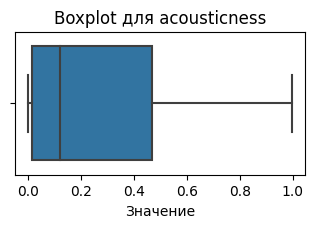

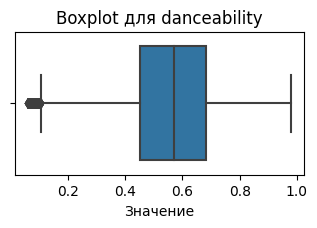

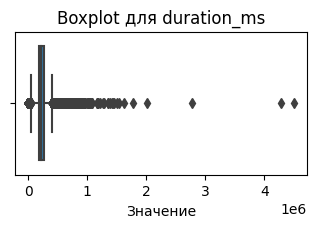

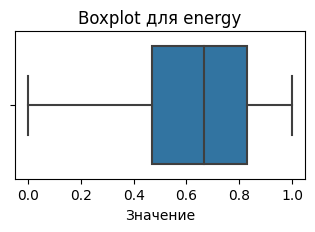

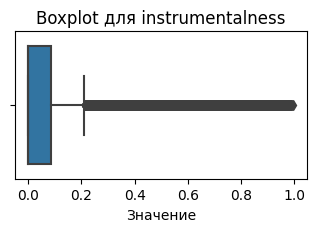

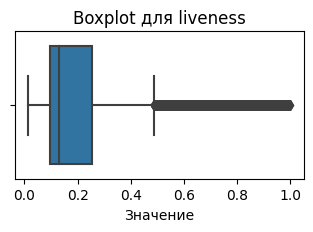

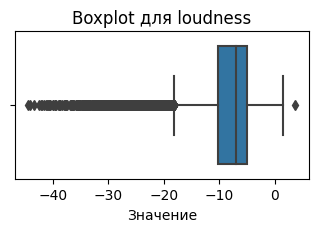

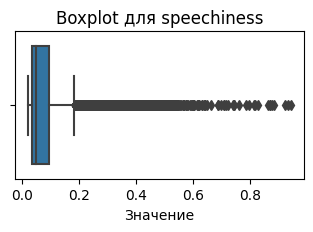

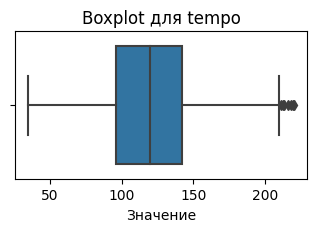

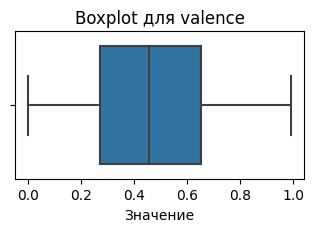

In [20]:
# Отберем из тренировочного сета числовые признаки,за исключением id трека 
df_num = df_train[df_train.columns.difference(['instance_id'], sort=False)].select_dtypes([float]) 

# Построим в цикле боксплот для каждого признака
for i,columns in enumerate(df_num.columns, 1): 
    fig = plt.figure(figsize=(10, 10))
    ax = plt.subplot(5,3,i) 
    sns.boxplot(data = df_num, x=df_num[columns]) 
    ax.set_xlabel('Значение') 
    ax.set_title(f'Boxplot для {columns}') 
    plt.tight_layout(w_pad=3) 
    plt.show()

**Итог:** Почти все признаки признаки имеют выбросы. В процессе предобработки данных нужно будет уменьшить их количество, чтобы модели лучше отработали.

### **2.2.4 Анализ распределения данных по признакам**

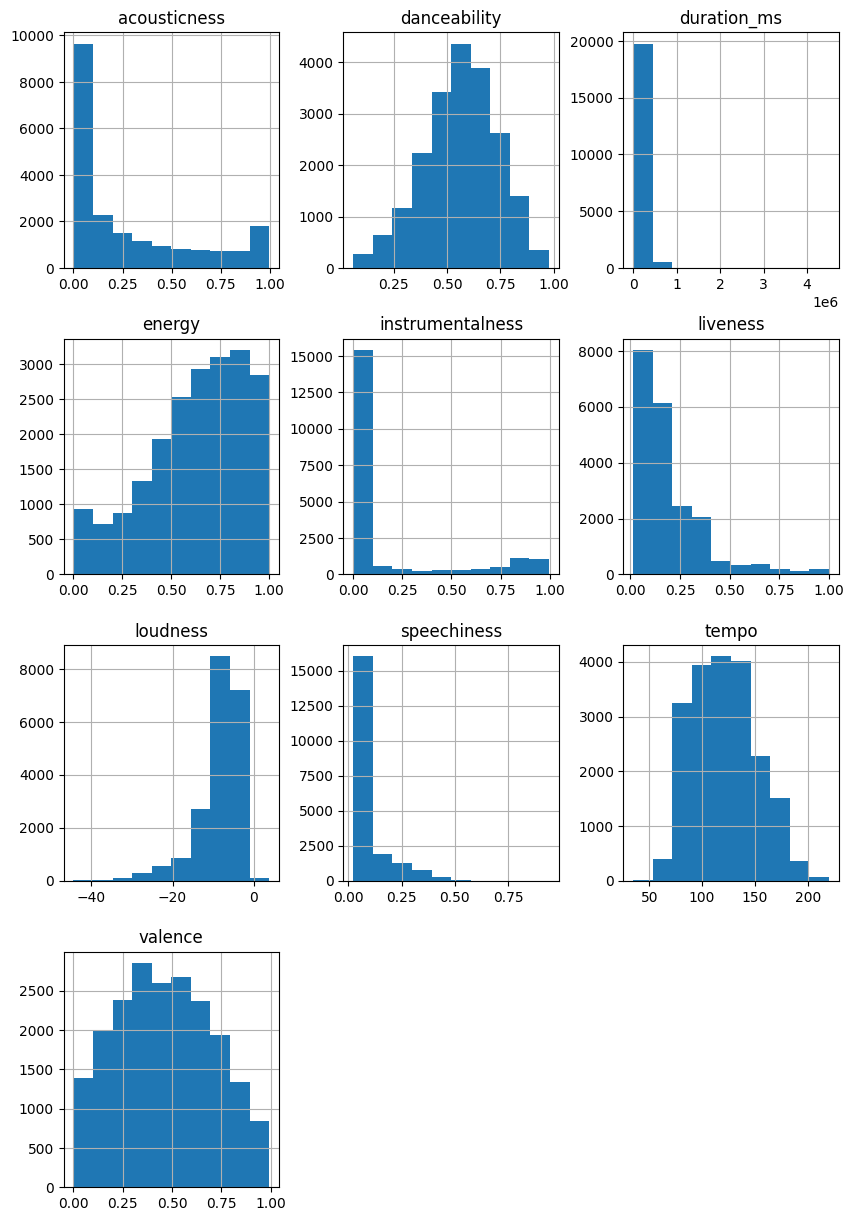

In [21]:
# Построим гистограмму распределения для каждого числового признака
df_num.hist(figsize=(10,15));

**Итоги:**
- Признаки `valence`, `tempo`, `danceability`  имеют распределение, близкое к нормальному
- Признаки `speechiness`, `livenes`, `instrumentalness`, `acousticness`, `duration_ms` имеют ярковыраженное левостороннее смещение
- Признаки `loudness`, `energy` имеют ярковыраженное правостороннее смещение
- В процессе предобработки можно немного уменьшить смещение, засчет исправления выбросов

### **2.2.5 Проверка признаков на мультиколинеарность**

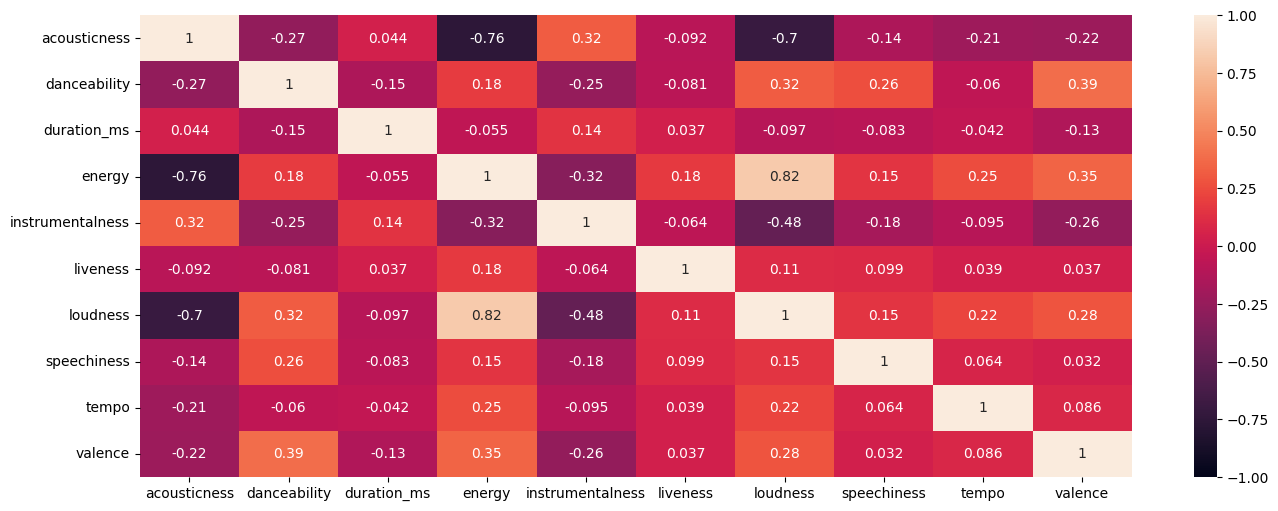

In [22]:
# Построим тепловую карту корреляции признаков
plt.figure(figsize=(16, 6)) 
sns.heatmap(data = df_num.corr(), vmin = -1, vmax = 1, annot = True);

**Итоги:**
- Признак `acousticness` имеет высокую степень корреляции с признаками `loudness` и `energy`, а два последних, в свою очередь, коррелируют друг с другом. Возможно, от этих признаков или части из них придется избавится, потому что такая зависимость может негативно повлиять на результаты работы модели
- Прослеживается взаимозависимость признаков `loudness` и `instrumentalness`, но не такая сильная. Ею можно пренебречь.
- Других зависимостей не обнаружено


### **2.2.6 Распределения категорий в целевом признаке**

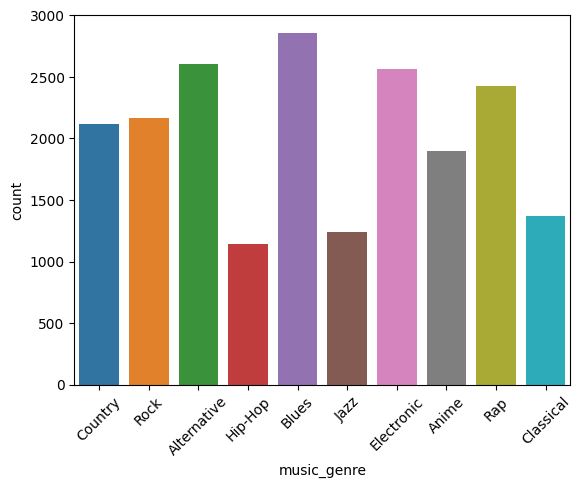

In [23]:
# Построим график количества по жанрам музыки
sns.countplot(data = df_train, x= df_train["music_genre"])
plt.xticks(rotation = 45)
plt.show()

In [24]:
# Посмотрим на те же данные в цифрах
df_train.groupby('music_genre')['instance_id'].count()

music_genre
Alternative    2601
Anime          1901
Blues          2858
Classical      1373
Country        2120
Electronic     2564
Hip-Hop        1145
Jazz           1239
Rap            2428
Rock           2165
Name: instance_id, dtype: int64

**Итог:** В целевом признаке присутствует некоторый дисбаланс классов. Его влияние нужно оценить непосредственно на работе модели, и в зависимости от этого, принять решение о необходимости балансировки


### **2.2.7 Распределения признаков по целевому признаку**

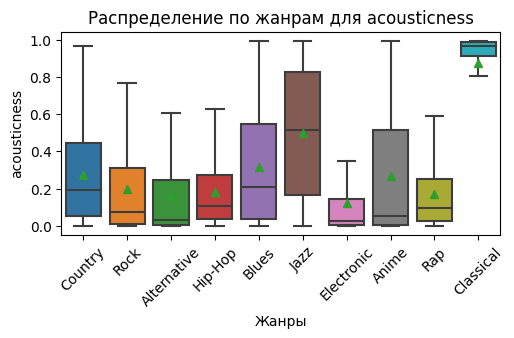

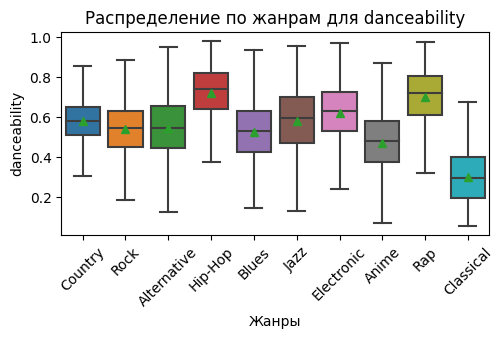

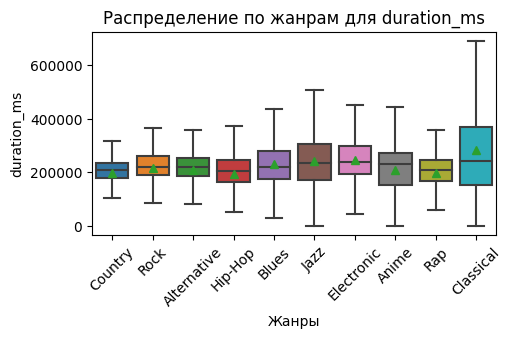

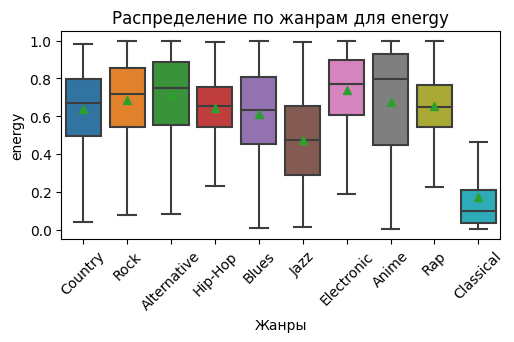

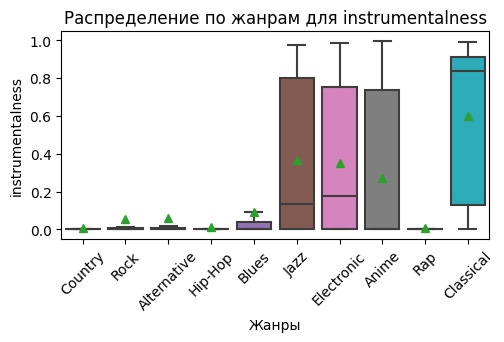

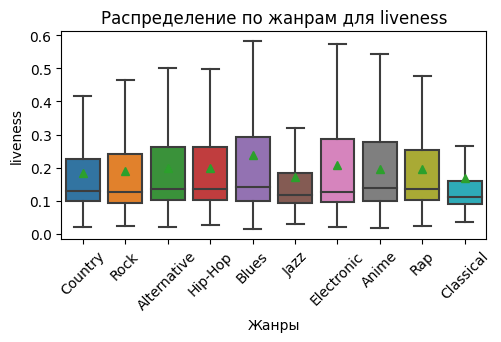

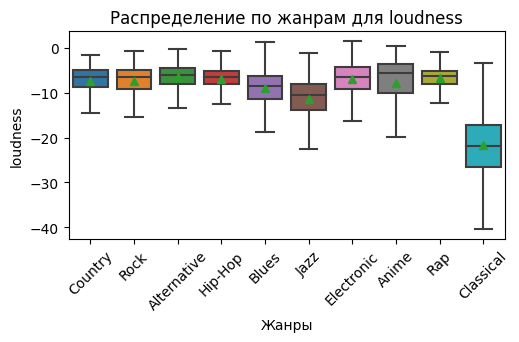

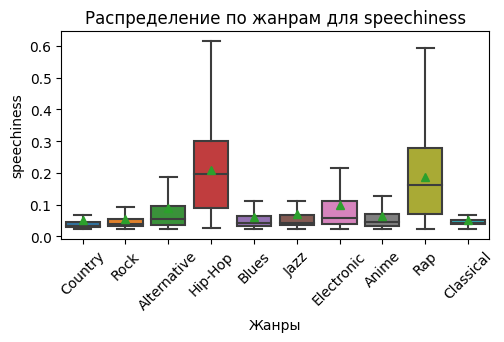

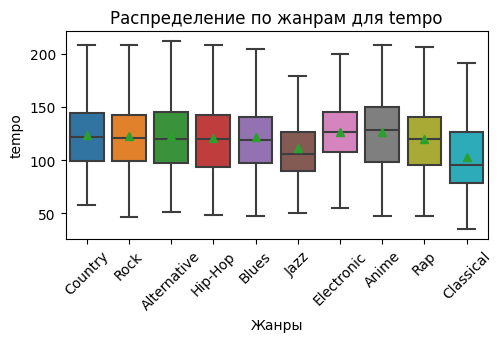

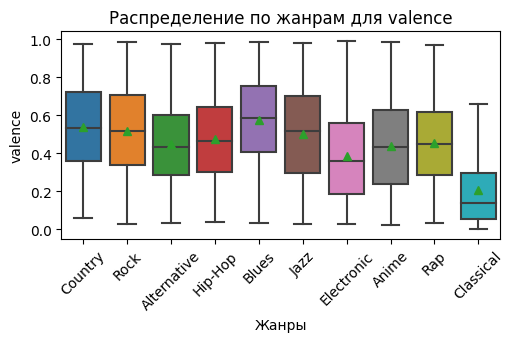

In [25]:
# Построим для каждого признака распределение его по жанрам
# Треугольником обозначим среднее значение

for i,columns in enumerate(df_num.columns, 1): 
    fig = plt.figure(figsize=(15, 15))
    ax = plt.subplot(5,3,i) 
    sns.boxplot(data = df_num, y=df_num[columns], x=df_train['music_genre'], showfliers=False, showmeans=True) 
    ax.set_xlabel('Жанры') 
    ax.set_title(f'Распределение по жанрам для {columns}')
    plt.xticks(rotation = 45)
    plt.tight_layout(w_pad=3) 
    plt.show()

**Итоги:**

Степень важности конкретного признака для предсказания того или иного жанра, можно определить по уровню его среднего значения.
- Наиболее сильное влияние признаки оказывают на следующие жанры:
  * **Classical** - `acousticness`, `duration_ms`, `instrumentalness`
  * **Hip-Hop**, **Rap** - `danceability`, `speechiness`
  * **Electronic** - `energy`
  
- Признаки, меньше всего влияющие на жанр:
  * **Classical** - `valence`, `loudness`, `energy`, `danceability`
  
- Остальные признаки имеют примерно одинаковую важность при выборе жанра



### **Вывод по результатам EDA**

В ходе исследовательского анализа выявлено следующее:
- Количество классов в целевом признаке - 10, а именно: **Country, Rock, Alternative, Hip-Hop, Вlues, Jazz,  Electronic, Anime, Rap, Classical**. В целевом признаке присутствует некоторый дисбаланс классов. Его влияние нужно оценить непосредственно на работе модели, и в зависимости от этого, принять решение о необходимости балансировки.
- Признак `key` имеет часть значений в виде одной буквы (**A,B,C,D,E,F,G**) и часть значений с дополнительным символом **#**. Это может быть обозначение музыкального знака *диез*, либо просто ошибкой 
- Признак `duration_ms` имеет много значений -1, что является ошибкой, поскольку отрицательной длительности звучания трека быть не может
- В обоих датасетах отсутствуют явные дубликаты. Тренировочный сет имеет 485 дубликатов, но с разным id и жанром музыки. Возможно, такие записи лучше удалить. Тестовый сет также имеет 30 аналогичных дубликатов, но в нем мы не можем удалять записи.
- Имеются пропуски в трех столбцах: `key`, `mode` и`tempo`. В обоих сетах имеются пропуски, как в категориальных так и в числовых признаках. Их количество достаточно велико - более 8% от всех записей. Поэтому просто удалить их будет неправильно, т.к. может сказаться на качестве работы моделей. Зависимости между пропущенными значениями не наблюдается, скорее всего пропуски носят случайный характер.
- Почти все признаки признаки имеют выбросы. В процессе предобработки данных нужно будет уменьшить их количество, чтобы модели лучше отработали.
- Признаки `valence`, `tempo`, `danceability`  имеют распределение, близкое к нормальному. Признаки `speechiness`, `livenes`, `instrumentalness`, `acousticness`, `duration_ms` имеют ярковыраженное левостороннее смещение. Признаки `loudness`, `energy` имеют ярковыраженное правостороннее смещение. В процессе предобработки можно немного уменьшить смещение, засчет исправления выбросов.
- Признак `acousticness` имеет высокую степень корреляции с признаками `loudness` и `energy`, а два последних, в свою очередь, коррелируют друг с другом. Возможно, от этих признаков или части из них придется избавится, потому что такая зависимость может негативно повлиять на результаты работы модели. Прослеживается взаимозависимость признаков `loudness` и `instrumentalness`, но не такая сильная. Ею можно пренебречь. Других зависимостей не обнаружено.
- Наиболее сильное влияние признаки оказывают на следующие жанры:
  * **Classical** - `acousticness`, `duration_ms`, `instrumentalness`
  * **Hip-Hop**, **Rap** - `danceability`, `speechiness`
  * **Electronic** - `energy`
- Признаки, меньше всего влияющие на жанр:
  * **Classical** - `valence`, `loudness`, `energy`, `danceability`
- Остальные признаки имеют примерно одинаковую важность при выборе жанра
- Количество классов в целевом признаке - 10, а именно: **Country, Rock, Alternative, Hip-Hop, Вlues, Jazz,  Electronic, Anime, Rap, Classical**
- Признак `mode` может принимать два значения : **Major** или **Мinor**. Значений **Major** больше, примерно вдвое
- Признак `key` имеет часть значений в виде одной буквы (**A,B,C,D,E,F,G**) и часть значений с дополнительным символом **#**. Это может быть обозначение музыкального знака *диез*, либо просто ошибкой 
- Признак `duration_ms` имеет много значений -1, что является ошибкой, поскольку отрицательной длительности звучания трека быть не может


## **2.3 Предобработка данных**

Поскольку данный проект участвовал в соревновании на Kaglle, процесс предобработки данных продолжался в течение всего времени, пока длилось соревнование. Постоянно проверялись какие-то версии и менялись варианты предобработки. Далее будет показана предобработка, которая привела к лучшему результату, а также будут пояснения о тех вариантах, которые рассматривались

* Создаем копию датасетов перед обработкой данных

In [26]:
data_train = df_train.copy()
len(data_train)

20394

In [27]:
data_test = df_test.copy()
len(data_test)

5099

* Убираем признак `obtained_date`, который не влияет на выбор жанра

In [28]:
data_train.drop(['obtained_date'], axis=1, inplace=True)
data_test.drop(['obtained_date'], axis=1, inplace=True)

> Также проверялся вариант с удалением признака `track_name`, но в итоге этот признак остался, т.к. модель с ним отработала лучше. Вероятно, результат был бы еще лучше, если бы текст был преобразован в какое-то числовое значение, но тут мне не хватило знаний. Изучить вопрос не успел, к сожалению.

* Удалим строки в тренировочном сете,в которых значение признака `duration_ms` равно -1 и пропуск на месте значения в `tempo`. Не могу объяснить логически почему удаление этих 42 строк положительно влияет на результат, но это факт. Набрел на него случайно, когда пробовал удалять записи с пропусками, пересекающиеся с такими же в других признаках. Ничего не улучшило показатель, кроме этого варианта. Хотя улучшение незначительное, конечно.

In [29]:
data_train = data_train[~((data_train['duration_ms'] == -1) & (data_train['tempo'].isna()))]

* Обрежем на уровне 10 минут столбец `duration_ms`, больше этого значения произведения быают редко

In [30]:
data_train.loc[data_train['duration_ms'] > 600000, 'duration_ms'] = 600000
data_test.loc[data_test['duration_ms'] > 600000, 'duration_ms'] = 600000

* Заменим значения в столбце, равные -1 медианой

In [31]:
data_train.loc[data_train['duration_ms'] == -1, 'duration_ms'] = data_train.loc[data_train['duration_ms'] != -1, 'duration_ms'].median()
data_test.loc[data_test['duration_ms'] == -1, 'duration_ms'] = data_test.loc[data_test['duration_ms'] != -1, 'duration_ms'].median()

> Также проверялся вариант замены на среднее значение и вообще удаление этих записей - оба результата получились хуже.
> Еще был вариант замены на основе предсказаний модели линейной регрессии, которая делала их с учетом других признаков. На этот метод возлагались большие надежды, но тем не менее, результат оказался хуже. 

* Обрежем столбец `loudness`на уровне -30 по левому краю, и на уровне 0 по правому краю. Дальше этих показателей находится очень мало записей

In [32]:
data_train.loc[(data_train['loudness'] < -30), 'loudness'] = -30
data_train.loc[(data_train['loudness'] > 0), 'loudness'] = 0

data_test.loc[(data_test['loudness'] < -30), 'loudness'] = -30
data_test.loc[(data_test['loudness'] > 0), 'loudness'] = 0

* Обрежем столбец `speechiness` на уровне 0.5 по правому краю

In [33]:
data_train.loc[(data_train['speechiness'] > 0.5), 'speechiness'] = 0.5
data_test.loc[(data_test['speechiness'] > 0.5), 'speechiness'] = 0.5

* Заменим пропуски в столбцах `key` и `mode` на моду

In [34]:
data_train['key'].fillna(data_train['key'].mode()[0], inplace=True)
data_train['mode'].fillna(data_train['mode'].mode()[0], inplace=True)

data_test['key'].fillna(data_test['key'].mode()[0], inplace=True)
data_test['mode'].fillna(data_test['mode'].mode()[0], inplace=True)

> Также были варианты удаления частичного или полного этих признаков, но результат был хуже. Еще был вариант удаления символа **#** в столбце `key`, он тоже не сработал

* Заменим пропуски в столбце `tempo` на медиану

In [35]:
data_train['tempo'].fillna(data_train['tempo'].isnull().median(), inplace=True)
data_test['tempo'].fillna(data_test['tempo'].isnull().median(), inplace=True)

> Также был вариант удаления пропусков, замену их на среднее
> Еще был вариант замены на основе предсказаний модели линейной регрессии, которая делала их с учетом других признаков. На этот метод возлагались большие надежды, но тем не менее, результат оказался хуже. Код для реализации такой замены показан ниже

>1.  lr = df_train.drop(['key','mode', 'music_genre'], axis = 1)
>
>2.  scaler = StandardScaler()
>
>3.  lr = pd.DataFrame(scaler.fit_transform(lr), columns = lr.columns)
>4.  test = lr[lr.tempo.isnull()].copy()
>5.  train = lr.dropna().copy()
>
>6.  y_train = train.tempo
>7.  X_train = train.drop('tempo', axis = 1)
>8.  X_test = test.drop('tempo', axis = 1)
>
>9.  lr_model = LinearRegression()
>10. lr_model.fit(X_train, y_train)
>11. y_pred = lr_model.predict(X_test)
>12. test.tempo = y_pred
>
>13. lr = pd.concat([train, test])
>14. lr.sort_index(inplace = True)
>15. lr = pd.DataFrame(scaler.inverse_transform(lr), columns = lr.columns)
>
>16. df_train.tempo = lr.tempo

* Поменяем тип данных в столбце `instance_id` на целочисленный

In [36]:
data_train.instance_id = data_train.instance_id.astype(int)

* Сделаем столбец `instance_id` индексом, т.к. влияния на выбор жанра он не оказывает, но при этом идентифицирует трек

In [37]:
data_train = data_train.set_index('instance_id')
data_train.index.names = [None]

data_test = data_test.set_index('instance_id')
data_test.index.names = [None]

* Смотрим на данные обоих сетов после предобработки

In [38]:
len(data_train)

20352

In [39]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20352 entries, 25143 to 86375
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_name        20352 non-null  object 
 1   acousticness      20352 non-null  float64
 2   danceability      20352 non-null  float64
 3   duration_ms       20352 non-null  float64
 4   energy            20352 non-null  float64
 5   instrumentalness  20352 non-null  float64
 6   key               20352 non-null  object 
 7   liveness          20352 non-null  float64
 8   loudness          20352 non-null  float64
 9   mode              20352 non-null  object 
 10  speechiness       20352 non-null  float64
 11  tempo             20352 non-null  float64
 12  valence           20352 non-null  float64
 13  music_genre       20352 non-null  object 
dtypes: float64(10), object(4)
memory usage: 2.3+ MB


In [40]:
data_train.head()

,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,music_genre
25143,Highwayman,0.4800,0.670,182653.0,0.351,0.017600,D,0.115,-16.842,Major,0.0463,101.384,0.450,Country
26091,Toes Across The Floor,0.2430,0.452,187133.0,0.670,0.000051,A,0.108,-8.392,Minor,0.0352,113.071,0.539,Rock
87888,First Person on Earth,0.2280,0.454,173448.0,0.804,0.000000,E,0.181,-5.225,Minor,0.3710,80.980,0.344,Alternative
77021,No Te Veo - Digital Single,0.0558,0.847,255987.0,0.873,0.000003,G#,0.325,-4.805,Minor,0.0804,116.007,0.966,Hip-Hop
20852,Chasing Shadows,0.2270,0.742,195333.0,0.575,0.000002,C,0.176,-5.550,Major,0.0487,76.494,0.583,Alternative


In [41]:
len(data_test)

5099

In [42]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5099 entries, 48564 to 47986
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_name        5099 non-null   object 
 1   acousticness      5099 non-null   float64
 2   danceability      5099 non-null   float64
 3   duration_ms       5099 non-null   float64
 4   energy            5099 non-null   float64
 5   instrumentalness  5099 non-null   float64
 6   key               5099 non-null   object 
 7   liveness          5099 non-null   float64
 8   loudness          5099 non-null   float64
 9   mode              5099 non-null   object 
 10  speechiness       5099 non-null   float64
 11  tempo             5099 non-null   float64
 12  valence           5099 non-null   float64
dtypes: float64(10), object(3)
memory usage: 557.7+ KB


In [43]:
data_test.head()

,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence
48564,Low Class Conspiracy,0.301000,0.757,146213.0,0.679,0.00000,A#,0.3030,-7.136,Minor,0.3560,90.361,0.895
72394,The Hunter,0.538000,0.256,240360.0,0.523,0.00832,G#,0.0849,-5.175,Major,0.0294,78.385,0.318
88081,Hate Me Now,0.005830,0.678,284000.0,0.770,0.00000,A,0.1090,-4.399,Minor,0.2220,90.000,0.412
78331,Somebody Ain't You,0.020300,0.592,177354.0,0.749,0.00000,B,0.1220,-4.604,Major,0.0483,160.046,0.614
72636,Sour Mango,0.000335,0.421,226108.5,0.447,0.01480,D,0.0374,-8.833,Major,0.2020,73.830,0.121


### **Вывод по результатам предобработки данных:**

В результате экспериментов и проверки разных схем предобработки данных, выбран следующий вариант(он показывает лучший результат при работе модели):
- Убираем признак `obtained_date`, который не влияет на выбор жанра.
- Удаляем строки в тренировочном сете,в которых значение признака `duration_ms` равно -1 и пропуск на месте значения в `tempo`.
- Обрезаем на уровне 10 минут столбец `duration_ms`, больше этого значения произведения быают редко.
- Заменяем значения в столбце, равные -1 медианой.
- Обрезаем столбец `loudness`на уровне -30 по левому краю, и на уровне 0 по правому краю. Дальше этих показателей находится очень мало записей.
- Обрезаем столбец `speechiness` на уровне 0.5 по правому краю
- Заменяем пропуски в столбцах `key` и `mode` на моду
- Заменяем пропуски в столбце `tempo` на медиану
- Поменяем тип данных в столбце `instance_id` на целочисленный
- Сделаем столбец `instance_id` индексом, т.к. влияния на выбор жанра он не оказывает, но при этом идентифицирует трек

После обработки тренировочный сет уменьшился на 42 строки (потеря около 0,2% данных). Размер тестового сета не изменился

## **2.4 Борьба с дисбалансом**

На этапе усовершенствования моделей было обучено три варианта моделей с существующим дисбалансом классов, с автоматической балансировкой, а также увеличение выборки при помощи ***SMOTE*** (пример кода показан ниже). Однако все эти действия не улучшили показатели моделей и в итоге от них отказались.

>1. oversample = SMOTE(random_state=12345, k_neighbors=4)
>2. features_upsampled, target_upsampled = oversample.fit_resample(features_train, target_train)

## **2.5 Выбор и обучение моделей**

В процессе работы над проектом были выбраны и обучены три модели машинного обучения:
- RandomForestClassifier
- GradientBoostingClassifier
- CatBoostClassifier

Для того, чтобы проверить метрику `f1-micro` данные тренировочного датасета были разделены на тренировочную а валидационную выборки. Все модели обучались и тестировались на них. Это позволило увидеть ориентировочное значение метрики, которое выдаст модель на тестовом датасете и, исходя из этого, сделать вывод о дальнейшей работе и усовершенствовании этих моделей. Кроме того, количество сабмитов для загрузки в Kaglle значительно сократилось.

Лучшую метрику показал  `CatBoostClassifier`, именно его мы и выбрали для окончательного тестирования.
Ниже будет показан код, который применялся для построения всех этих моделей, а также подготовка признаков, которая была сделана.
Ячейки с кодом для неиспользуемых в окончательном варианте моделей будут "закоментированы", чтобы не нарушать работу основного кода.

* Подготовим признаки для работы с моделями

In [44]:
features = data_train.drop('music_genre', axis = 1)
target = data_train['music_genre']

In [45]:
#features_train, features_valid, target_train, target_valid = train_test_split(
#     features, target, test_size=0.25, 
#     stratify = target, random_state=12345)

*  Обозначим категориальные признкаи

In [46]:
ohe_features = features.select_dtypes(include='object').columns.to_list()
ohe_features

['track_name', 'key', 'mode']

In [47]:
# ohe_features = features_train.select_dtypes(include='object').columns.to_list()
# ohe_features

* Обозначим числовые признаки

In [48]:
# num_features = features_train.select_dtypes(include='float').columns.to_list()
# num_features

* Закодируем категориальные  и стандартизируем числовые признаки

In [49]:
# encoder_ohe = OneHotEncoder(drop='first', handle_unknown='error', sparse=False)

# encoder_ohe.fit(features_train[ohe_features])

# features_train[
#     encoder_ohe.get_feature_names_out()
# ] = encoder_ohe.transform(features_train[ohe_features])

# features_train = features_train.drop(ohe_features, axis=1)

# scaler = StandardScaler()

# features_train[num_features] = scaler.fit_transform(features_train[num_features])

In [50]:
# # энкодером, который обучен на ТРЕНИРОВОЧНОЙ ВЫБОРКЕ, кодируем тестовую
# features_valid[
#     encoder_ohe.get_feature_names_out()
# ] = encoder_ohe.transform(features_valid[ohe_features])

# features_valid = features_valid.drop(ohe_features, axis=1)

# # скелером, который обучен на ТРЕНИРОВОЧНОЙ ВЫБОРКЕ, масштабируем тестовую
# features_valid[num_features] = scaler.transform(
#      features_valid[num_features]
# )

* Построение и обучение модели случайного леса

In [51]:
# best_f1_rfc = 0
# best_est = 0
# best_depth_rfc = 0

# for est in range(1,20,1):
#     for depth in range(1,10,1):
#         model_rfc = RandomForestClassifier(max_depth=depth,
#                                            n_estimators=est, random_state=12345)
#         model_rfc.fit(features_train, target_train)
#         predicted_rfc = model_rfc.predict(features_valid)
#         rfc_f1 = f1_score(target_valid, predicted_rfc, average='micro')
#         if rfc_f1 > best_f1_rfc:
#             best_f1_rfc = rfc_f1
#             best_est = est
#             best_depth_rfc = depth

# print("Лучшее значение f1:", best_f1_rfc)
# print("Лучшее количество деревьев:", best_est)
# print("Лучшая глубина дерева:", best_depth_rfc)

* Построение и обучение модели GradientBoostingClassifier

In [52]:
# gbc = GradientBoostingClassifier(n_estimators=280,
#                                  learning_rate=0.1,
#                                  random_state=12345,
#                                  max_features=5,
#                                  max_depth=3)
# gbc.fit(features_train, target_train)
# pred_y = gbc.predict(features_valid)
# micro_f1 = f1_score(target_valid, pred_y, average='micro')
# micro_f1

* Построение и обучение модели CatBoostClassifier. Параметры подбирались по сетке

>1. parameters = {'depth': [3,5,7],
>2.               'learning_rate':[0.01,0.1,0.2],
>3.               'iterations': [100,250,350,500]
              }

In [53]:
model = CatBoostClassifier(iterations=350, depth=5, learning_rate=0.1, 
                           cat_features=ohe_features, loss_function='MultiClass', random_state=12345)
model.fit(features, target)

0:	learn: 2.1910517	total: 213ms	remaining: 1m 14s
1:	learn: 2.1126046	total: 359ms	remaining: 1m 2s
2:	learn: 2.0531329	total: 500ms	remaining: 57.8s
3:	learn: 1.9969180	total: 646ms	remaining: 55.9s
4:	learn: 1.9506557	total: 787ms	remaining: 54.3s
5:	learn: 1.9107841	total: 928ms	remaining: 53.2s
6:	learn: 1.8816371	total: 1.07s	remaining: 52.4s
7:	learn: 1.8512065	total: 1.21s	remaining: 51.9s
8:	learn: 1.8247329	total: 1.35s	remaining: 51.2s
9:	learn: 1.8011838	total: 1.49s	remaining: 50.6s
10:	learn: 1.7767041	total: 1.63s	remaining: 50.3s
11:	learn: 1.7543279	total: 1.77s	remaining: 49.9s
12:	learn: 1.7368767	total: 1.92s	remaining: 49.7s
13:	learn: 1.7197858	total: 2.06s	remaining: 49.4s
14:	learn: 1.7039384	total: 2.2s	remaining: 49.1s
15:	learn: 1.6884472	total: 2.33s	remaining: 48.7s
16:	learn: 1.6738973	total: 2.47s	remaining: 48.4s
17:	learn: 1.6633923	total: 2.61s	remaining: 48.2s
18:	learn: 1.6506764	total: 2.75s	remaining: 47.9s
19:	learn: 1.6398565	total: 2.89s	remaini

* Делаем переменную с предсказаниями

In [54]:
y_pred = model.predict(data_test)
submit = pd.DataFrame(y_pred)
submit

,0
0,Rap
1,Blues
2,Rap
3,Country
4,Alternative
...,...
5094,Country
5095,Rap
5096,Rap
5097,Electronic


* Подставляем предсказания в тестовый датасет и формируем файл для отправки 

In [55]:
df_test_pred = data_test.drop(['track_name','acousticness','danceability','duration_ms','energy','instrumentalness',
                           'valence','liveness','loudness','mode','speechiness','tempo'], axis=1)
df_test_pred.reset_index(inplace=True)
df_test_pred['key'] = submit
df_test_pred.rename(columns={'key' : 'music_genre', 'index':'instance_id'}, inplace=True)


df_test_pred

,instance_id,music_genre
0,48564,Rap
1,72394,Blues
2,88081,Rap
3,78331,Country
4,72636,Alternative
...,...,...
5094,50532,Country
5095,26255,Rap
5096,67924,Rap
5097,79778,Electronic


* Сохраняем файл с предсказаниями в нужном виде

In [56]:
df_test_pred.to_csv(r'C:\Users\Sergei\Desktop\submit.csv', index=False)

### **Вывод по результатам выбора и обучения модели:**

В процессе работы над проектом были выбраны и обучены три модели машинного обучения:
- RandomForestClassifier
- GradientBoostingClassifier
- CatBoostClassifier

Лучшую метрику показал  `CatBoostClassifier`
Параметры лучшей модели `depth` - *5*, `learning_rate` - *0.1*, `iterations` - *350*, `loss_function` = *MultiClass*

## **2.6 Анализ важности признаков**

* Для оценки важности признаков построим барплот

In [57]:
def plot_feature_importance(importance,names,model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)


    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)


    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)


    plt.figure(figsize=(10,8))

    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + ' Важность признаков')
    plt.xlabel('Важность признаков')
    plt.ylabel('Признаки')

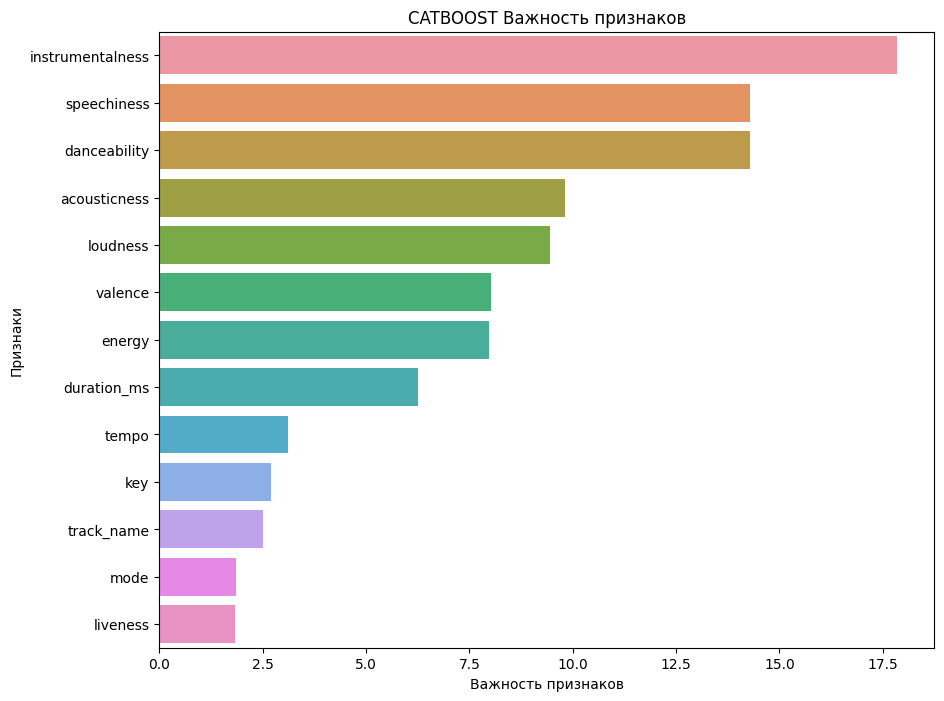

In [58]:
 plot_feature_importance(model.get_feature_importance(),features.columns,'CATBOOST')

### **Вывод**

График наглядно показал какие признаки модель посчитала наиболее важными. Как видно, самые важные признаки - инструментальность, выразительность и танцевальность. Наименее важные - привлекательность, тональность, имя трэка

В ходе проекта было сделано несколько вариантов ручной настройки важности признаков через гиперпараметры, но лучше результат не стал, модель выбрала оптимальный.

# **3. Результаты и выводы**

В процессе работы над проектом была проделана большая работа по нахождению лучшего варианта предобработки данных и подбора параметров модели. На протяжении всего хода соревнования было сделано около 50 вариантов решения данной задачи, из них 10 были выложены в Kaglle. В итоге найдена лучшая комбинация признаков и их обработки, лучшая модель обучения и оптимальные параметры.

В итоге:

* Лучшая модель - CatBoostClassifier`
* Параметры лучшей модели `depth` - *5*, `learning_rate` - *0.1*, `iterations` - *350*, `loss_function` = *MultiClass*
* Показатель метрики `f1-micro`, которого удалось добиться - **0,5288**
